In [13]:
Ueff = Ueff_fault_only;
x_dofs = py"lambda x: x.tabulate_dof_coordinates()"(scalar_fs.pyobject);

_, stress_from_ueff = constdispstress(slip2dispstress, x_dofs[:,1], x_dofs[:,2], elsbox, BRTL_idx,
                                      Ueff[1:2:end], Ueff[2:2:end], mu, nu)

# set stress_from_ueff values to zero when they are outside the box domain.
stress_from_ueff[x_dofs[:,1] .<= L, :] .= 0
stress_from_ueff[x_dofs[:,1] .>= R, :] .= 0
stress_from_ueff[x_dofs[:,2] .<= B, :] .= 0
stress_from_ueff[x_dofs[:,2] .>= T, :] .= 0

fenics_stress_dofs = zeros(4,size(x_dofs)[1])
fenics_stress_dofs[1,:] = stress_from_ueff[:,1]
fenics_stress_dofs[2,:] = stress_from_ueff[:,3]
fenics_stress_dofs[3,:] = stress_from_ueff[:,3]
fenics_stress_dofs[4,:] = stress_from_ueff[:,2];
sigma = FeFunction(tensor_fs)
py"lambda x, vs: x.vector().set_local(vs)"(sigma.pyobject, reshape(fenics_stress_dofs, (:)))

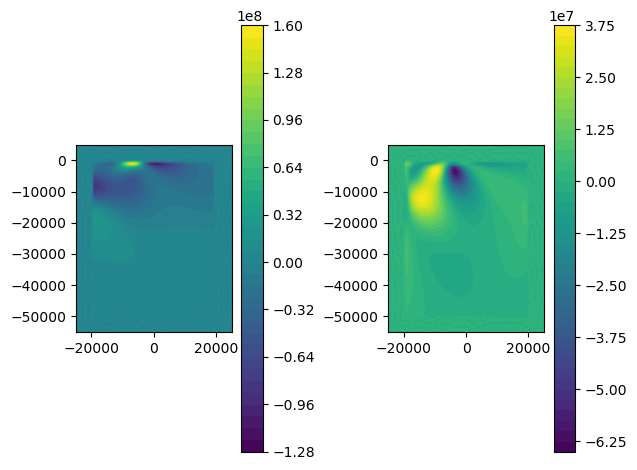

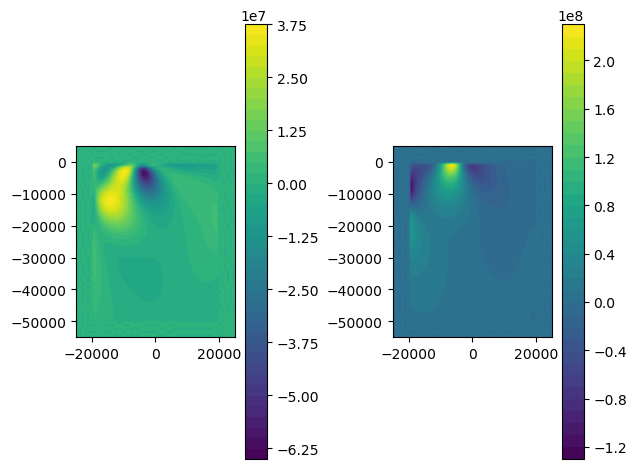

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [14]:
fenics_plot_vec2d(FEniCS.dot(sigma, Constant((1.0, 0.0))))
fenics_plot_vec2d(FEniCS.dot(sigma, Constant((0.0, 1.0))))

In [15]:
# no viscous behavior in the surface layer, mu/eta below VE_z
# We can't use a threshold for eta because we divide by eta and dividing by zero is bad.
fenics_mu_over_eta = interpolate(Expression("0.0 + mu/eta*(x[1] <= VE_z)", degree=0, mu=mu, eta=eta, VE_z=VE_z), scalar_fs)

# https://en.wikipedia.org/wiki/Cauchy_stress_tensor#Stress_deviator_tensor
stress_deviator = sigma - (1.0/3)*FEniCS.tr(sigma)*Identity(2);

dVdt = project(fenics_mu_over_eta * div(stress_deviator), vector_fs)

"Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 12), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 108)"

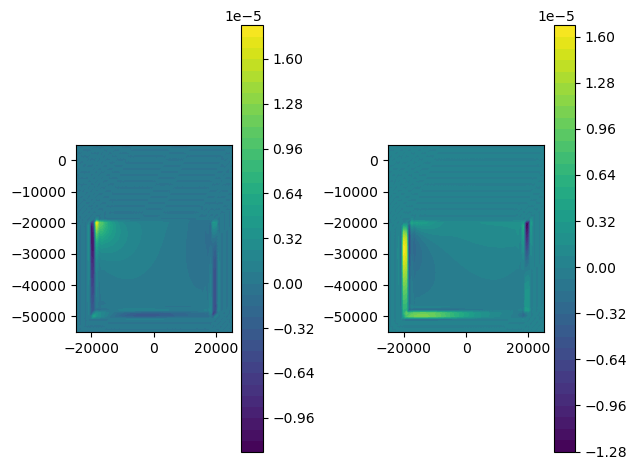

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [16]:
fenics_plot_vec2d(dVdt)

Let's assume dVdt is constant for 1000 years. This is obviously wrong but will let us use dVdt @ t = 0 to determine what behavior is happening as a result of viscoelasticity. The result below seems reasonable: flow happens below the fault and below 20km depth. The elastic effects of this flow are visible above 20km depth. There's an obvious edge effect at the left edge. I'm not sure if this is due to the singularities in the calculation of dVdt (and thus, is in an error) or due to the traction free BC (and thus, is correct physical behavior).

In [45]:
siay = 365.25 * 24 * 60 * 60
Ve_force = dVdt * 1000 * siay

fenics_u = fenics_solve(vector_fs, Ve_force)

sxx_sxy, sxy_syy = fenics_tensor_components(vector_fs, fenics_stress(fenics_u, lambda, mu))

bcs_B = -fenics_eval_u(fenics_u, idx["B"], elsbox.xcenter, elsbox.ycenter)
bcs_RTL_S = -fenics_eval_s(sxx_sxy, sxy_syy, RTL_idx, elsbox.xcenter, elsbox.ycenter)
bcs_RTL = stress_to_trac(bcs_RTL_S, RTL_idx, elsbox.xnormal, elsbox.ynormal);

Ufem = transpose(reshape(fenics_eval_u(fenics_u, 1:length(xgrid), xgrid, ygrid), (2,:)))
Sfem = transpose(reshape(fenics_eval_s(sxx_sxy, sxy_syy, 1:length(xgrid), xgrid, ygrid), (3,:)));

bcs_ve_fem = zeros(2 * elsbox.endidx - 2)
bcs_ve_fem[1:2*nside] = bcs_B
bcs_ve_fem[2*nside+1:end] = bcs_RTL;

bcscombined = bcs_fault_only .+ bcs_ve_fem
Ueffcombined = THbox \ bcscombined;

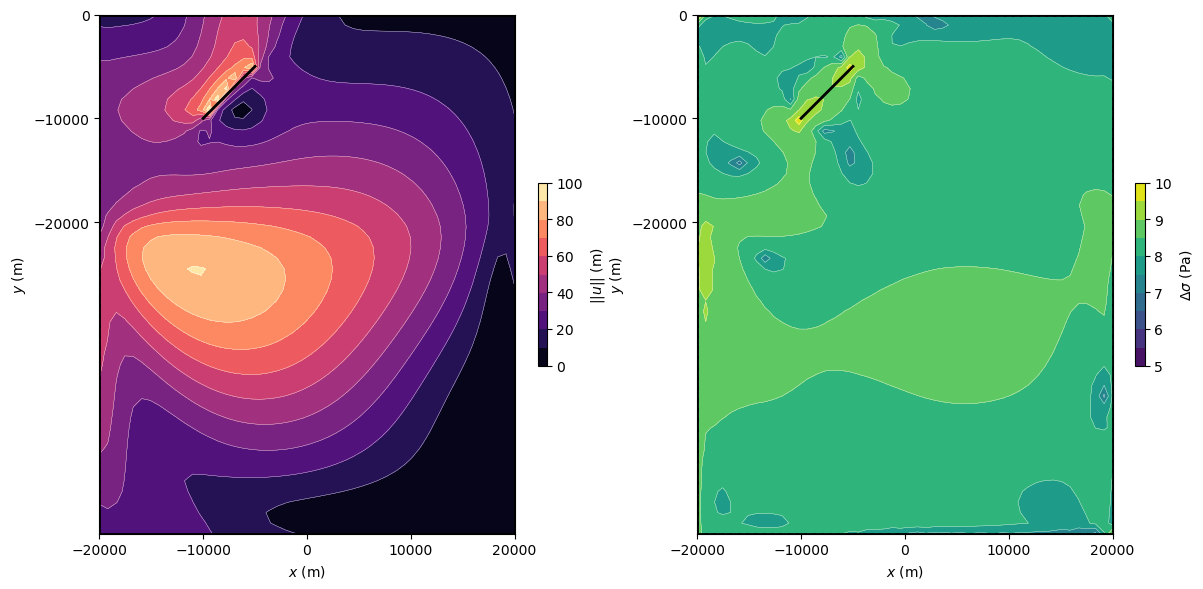

In [49]:
UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                           Ueffcombined[1:2:end], Ueffcombined[2:2:end], mu, nu)
Utotal = UTB .+ UF .+ Ufem
Stotal = STB .+ SF .+ Sfem
twopanel(xgrid, ygrid, npts, Utotal, Stotal, idx, elsbox, figsize=(12,6), ylim=[B,T]);